# 하이퍼파라메터 튜닝을 통한 모델 정교화

시작점이 되는 기준 모델(baseline model)을 만듭니다.

In [ ]:
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np


iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 간단한 신경망 모델을 만듭니다
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

## 1. Cross Validation

Train/test split을 통해 overfitting을 막을 수 있지만, split이 어떻게 되는지에 따라 이 결과가 달라질 수 있겠죠. 그래서 이걸 더 강건하게 하는 것이 Cross validation입니다. 즉, split을 여러 차례 다른 방식으로 하는 것이죠.

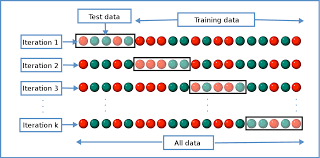

In [ ]:
# Cross validation
from sklearn.model_selection import KFold

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train, test in kfold.split(X):
    model = create_model()
    model.fit(X[train], y[train], epochs=100, verbose=0)
    scores = model.evaluate(X[test], y[test], verbose=0)
    cv_scores.append(scores[1])  # scores[1] is accuracy

cv_scores = np.array(cv_scores)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

- 교차 검증을 사용하여 모델의 성능을 평가합니다.
- `cross_val_score` 함수를 사용하여 5-폴드 교차 검증을 수행합니다.
- 각 폴드의 정확도를 출력하고, 평균 정확도를 계산합니다.

## Hyperparameter Tuning

모델에 들어가는 옵션들이 있었죠. 예를 들면 랜덤포레스트에서는 트리의 갯수나 깊이에 해당할 것이고, 신경망에서는 optimizer 등이 있었습니다. 이들 중 최적값을 찾는 과정입니다.

### GridSearch

In [ ]:
from sklearn.model_selection import ParameterGrid, ParameterSampler
from scipy.stats import randint

def create_model(optimizer='adam'):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

param_grid = {
    'epochs': [50, 100],
    'optimizer': ['adam', 'sgd']
}

param_grid

In [ ]:
# 실행 (주의: 시간이 오래 소요될 수 있습니다)
best_score = 0
best_params = {}

for params in ParameterGrid(param_grid):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train, test in kfold.split(X):
        model = create_model(optimizer=params['optimizer'])
        model.fit(X[train], y[train], epochs=params['epochs'], batch_size=16, verbose=0)
        score = model.evaluate(X[test], y[test], verbose=0)[1]
        scores.append(score)

    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("Best parameters found by GridSearch:")
print(best_params)
print(f"Best score: {best_score:.4f}")

### RandomSearch

In [ ]:
param_dist = {
    'epochs': randint(50, 150),
    'batch_size': randint(16, 64),
    'optimizer': ['adam', 'sgd', 'rmsprop']
}

best_score = 0
best_params = {}

param_list = list(ParameterSampler(param_dist, n_iter=10, random_state=42))

In [ ]:
# 실행 (주의: 시간이 오래 소요될 수 있습니다)
for params in param_list:
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train, test in kfold.split(X):
        model = create_model(optimizer=params['optimizer'])
        model.fit(X[train], y[train], epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
        score = model.evaluate(X[test], y[test], verbose=0)[1]
        scores.append(score)

    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("Best parameters found by RandomSearch:")
print(best_params)
print(f"Best score: {best_score:.4f}")

- `GridSearchCV`와 `RandomizedSearchCV`를 사용하여 모델의 최적 하이퍼파라미터를 찾습니다.
- `param_grid`와 `param_dist`를 정의하여 각각의 검색 방법을 설정합니다.
- 각 방법으로 찾은 최적의 하이퍼파라미터를 출력합니다.

## AutoML (feat. H2O)

H2O AutoML을 사용한 자동 머신러닝

H2O를 사용하려면 데이터를 H2OFrame이라는 특별한 형식으로 바꿔야 합니다. 

In [ ]:
# H2O를 이용한 AutoML
import h2o
from h2o.automl import H2OAutoML

h2o.init()

# 데이터를 H2OFrame
iris_h2o = h2o.H2OFrame(iris.data)
iris_h2o['species'] = h2o.H2OFrame(iris.target)

# Train/test
train, test = iris_h2o.split_frame(ratios=[0.8])

H2O AutoML을 사용하여 자동으로 최적의 모델을 찾습니다. (3분 전후로 소요됩니다)

In [ ]:
aml = H2OAutoML(max_runtime_secs=120, seed=1)
aml.train(x=list(range(4)), y='species', training_frame=train)

모델들 간의 비교 평가를 보여주는 리더보드를 출력합니다.

In [ ]:
lb = aml.leaderboard
print(lb.head())

리더보드에서 최적의 모델을 선택하고, 테스트 세트에서 성능을 평가합니다.

In [ ]:
# Evaluate best model
best_model = aml.leader
performance = best_model.model_performance(test)
print(performance)

H2O 작업이 끝났으므로 H2O와의 연결을 종료합니다.

In [ ]:
h2o.shutdown()